#### Imports and settings

In [49]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import time
import datetime
import json
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import markovify as mk
from wordcloud import WordCloud, STOPWORDS

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import Constant

# Metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score
from imblearn.metrics import specificity_score, sensitivity_score

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
tf.logging.set_verbosity(tf.logging.ERROR)

%matplotlib inline
%reload_ext jupyternotify

print('Intel-optimized TensorFlow is enabled:', tf.pywrap_tensorflow.IsMklEnabled())

<IPython.core.display.Javascript object>

Intel-optimized TensorFlow is enabled: True


In [2]:
time_flag = 0

# Tap first time to start, tap second time to stop
def tap_timer(time_marker, start):
    now = time.time()
    elapsed_seconds = round(now - time_marker)
    time_marker = now    
    if not start:
        print('\nOperation took %s [hh:mm:ss]' % datetime.timedelta(seconds=elapsed_seconds))
    return time_marker

In [3]:
# Parametrize architecture of model
architecture_params = {}
markov_oversamping_params = {}
pretrained_embedding_params = {}

markov_oversamping_params['oversample_with_markov'] = { 'name': 'Markov oversampling', 'value': False }
markov_oversamping_params['include_clean_class'] = { 'name': 'Clean class by Markov', 'value': False }
markov_oversamping_params['acceptable_imbalance_factor'] = .2

pretrained_embedding_params['use_pretrained_embedding'] = { 'name': 'Pretrained embeddings', 'value': False }
pretrained_embedding_params['active_embedding'] = 'glove' # ignored when 'use_pretrained_embedding' is False

architecture_params['use_class_weightening'] = { 'name': 'Class weightening', 'value': False }
architecture_params['markov_oversamping'] = markov_oversamping_params
architecture_params['pretrained_embedding'] = pretrained_embedding_params

In [4]:
def check_architecture_config(architecture_param):
    state = 'active' if architecture_param['value'] else 'inactive'
    message = 'Following architecture parameter: \'{0}\' is {1}\n'.format(architecture_param['name'], state)
    print(message)
    return architecture_param['value']

#### Customize IDE (currently raw)

In [5]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams["figure.figsize"] = [10,5]

#### Load datasets and pretrained models

In [6]:
INPUT_PATH = '../input/'
SUBMISSION_PATH = '../submission/'
MODEL_PATH = '../model/'
PRETRAINED_PATH = '../pretrained-models/'

train = pd.read_csv(f'{INPUT_PATH}train.csv')
test = pd.read_csv(f'{INPUT_PATH}test.csv')
test_labels = pd.read_csv(f'{INPUT_PATH}test_labels.csv')

### EDA (Exploratory data analysis)

In [7]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
n_train = train.shape[0]
n_test = test.shape[0]

print("Samples in train dataset: {0} ({1} %)".format(n_train, round(n_train * 100 / (n_train + n_test))))
print("Samples in test dataset: {0} ({1} %)".format(n_test, round(n_test  *100 / (n_train + n_test))))

Samples in train dataset: 159571 (51 %)
Samples in test dataset: 153164 (49 %)


In [11]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

comments_labels_train = train_extended.iloc[:,2:]
train_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (train_labels_sums == 0)

n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples

print("Clean: {0} ({1} %)".format(n_clean_samples, round(n_clean_samples * 100 / len(train_extended))))
print("Toxic: {0} ({1} %)".format(n_toxic_samples, round(n_toxic_samples * 100 / len(train_extended))))

Clean: 143346 (90.0 %)
Toxic: 16225 (10.0 %)


###### <font color="LIGHTSALMON">The large majority of train dataset are comments labelled as clean</font>

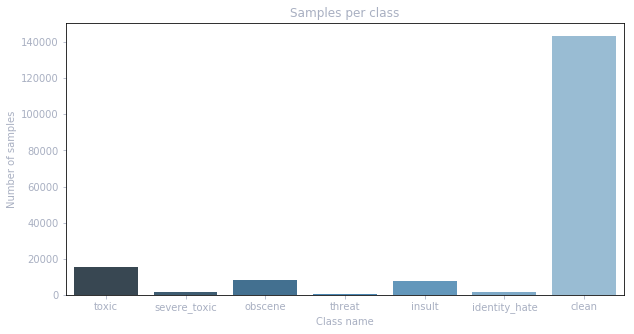

In [12]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

In [13]:
def calculate_imbalance_ratios(summed_labels):
    imbalance_ratios_class_names = {}
    imbalance_ratios_class_nums = {}
    for label in range(len(summed_labels)):
        ratio_label = n_clean_samples / summed_labels.get(label)
        imbalance_ratios_class_nums[label] = round(ratio_label, 2)
        imbalance_ratios_class_names[summed_labels.index[label]] = round(ratio_label, 2)      
    return imbalance_ratios_class_names, imbalance_ratios_class_nums

# Define original imbalance
original_imbalance_names, original_imbalance_nums = calculate_imbalance_ratios(summed_labels_extended_train)

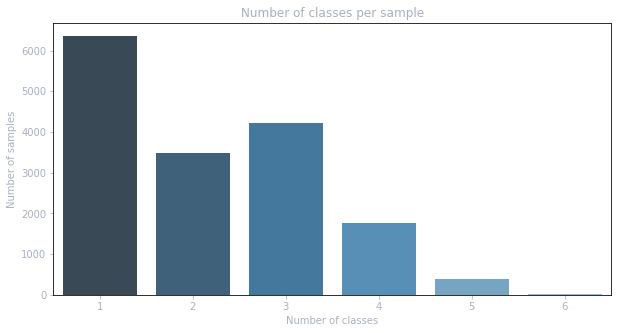

In [14]:
# without '0 classes' (clean comments)
multiple_classes_occurance = train_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()

In [15]:
print("Single-classed toxic comments:", '{0:.2f}'.format(
    multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(
    multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="LIGHTSALMON">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [16]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class), 1]

toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n>", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

> "

 Another crap article 
Parrots what promotion websites of capoeira schools say about myths of origin. And also that persecution thing. By the late 1800s, capoeira became a word for street brawling. Thus, authorities did not prohibit or sanction ""practice"" of capoeira. In banning capoeira they were banning outright street brawls! It's why Mestre Bimba presented his art as Luta Regional Baiana. No decent carioca would be eager to sympathise with capoeira and malandrismo. I could attempt to alter the article but it's become such a mess by now.   "

 --- 

Severe toxic:

> FUCK YOU 

FUCK YOU ASSHOLE

 --- 

Obscene:

> Go Fuck Yourself 

Deeside College is a mother fucking spunk dunk pottery which is held at User:GaryColemanFan .com
and likes to suck Georg Hackenschmidt of and doesn't accept facebook Groups like the official Facebook Professional Wrestling Hall Of Fame (  )

 --- 

Threat:

> Go fuck yourself!!! you fucking delteted it anyway! whats the fucking point of a p

#### Wordclouds

In [17]:
time_flag = tap_timer(time_flag, start=True)

stopwords=set(STOPWORDS)

wordcloud_toxic = WordCloud(max_words=1000, stopwords=stopwords, colormap="Reds")
wordcloud_toxic.generate(" ".join(toxic_samples.comment_text.values))
wordcloud_clean = WordCloud(max_words=1000, stopwords=stopwords, colormap="Greens")
wordcloud_clean.generate(" ".join(clean_samples.comment_text.values))

time_flag = tap_timer(time_flag, start=False)


Operation took 0:00:49 [hh:mm:ss]


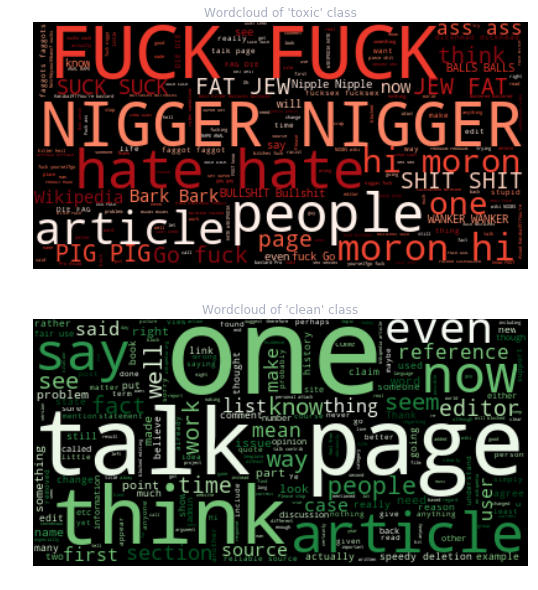

In [18]:
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.title("Wordcloud of \'toxic\' class")
plt.imshow(wordcloud_toxic, interpolation='bilinear')
plt.axis("off")

plt.subplot(212)
plt.axis("off")
plt.title("Wordcloud of \'clean\' class")
plt.imshow(wordcloud_clean, interpolation='bilinear')

plt.show()

#### Feature Engineering

###### <font color="LIGHTSALMON">Spam ratio (coefficient) =  unique words in comment / number of words in comment</font>

In [19]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = train_extended['n_unique_words'] * 100 / train_extended['n_words']

spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]

print('For spam coefficient equal 10%:\n')
print('Clean spammers: {0} ({1} %)'.format(n_clean_spammers, round(n_clean_spammers * 100 / n_spammers)))
print('Toxic spammers: {0} ({1} %)'.format(n_toxic_spammers, round(n_toxic_spammers * 100 / n_spammers)))
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers), 
      'times more toxic spammers than clean ones!')

For spam coefficient equal 10%:

Clean spammers: 67 (19 %)
Toxic spammers: 292 (81 %)

There are 4.36 times more toxic spammers than clean ones!


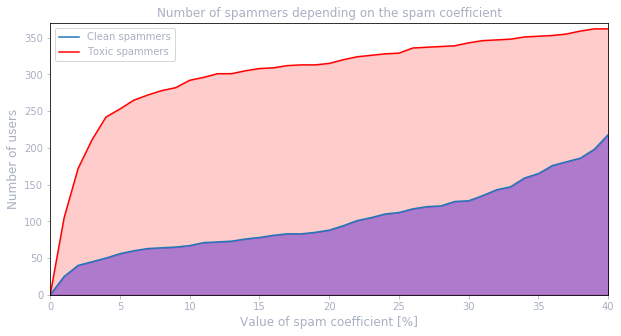

In [20]:
# Prepare data for plot
spam_ratio_values = np.arange(0, 41, 1)
n_clean_spammers_values = []
n_toxic_spammers_values = []
for spam_ratio in spam_ratio_values:
    curr_spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
    curr_clean_spammers = curr_spammers[curr_spammers['clean'] == True]
    curr_toxic_spammers = curr_spammers[curr_spammers['clean'] == False]
    n_clean_spammers_values.append(curr_clean_spammers.shape[0])
    n_toxic_spammers_values.append(curr_toxic_spammers.shape[0])

# Create plot
plt.title("Number of spammers depending on the spam coefficient", fontsize=12)

plt.plot(spam_ratio_values, n_clean_spammers_values)
plt.fill_between(spam_ratio_values, n_clean_spammers_values, 0, color='blue', alpha=0.4)  
plt.plot(spam_ratio_values, n_toxic_spammers_values, 'r')
plt.fill_between(spam_ratio_values, n_toxic_spammers_values, 0, color='red', alpha=0.2) 

plt.legend(['Clean spammers', 'Toxic spammers'])
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Value of spam coefficient [%]', fontsize=12)
plt.xlim(0, 40)
plt.ylim(0, 370)
plt.show()

In [21]:
spam_min_index = min(n_clean_spammers, n_toxic_spammers) - 1

print("Sample clean spam:\n\n>", clean_spammers.iloc[randint(0, spam_min_index)].comment_text)
print("\n --- \n\nSample toxic spam:\n\n>", toxic_spammers.iloc[randint(0, spam_min_index)].comment_text)

Sample clean spam:

> BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE BYE

 --- 

Sample toxic spam:

> Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks
Bollocks all is bollocks


##### Create synthetic training data using a Markov chain generator

In [22]:
# Decide if clean class should be added to labels
extend_labels_by_clean = check_architecture_config(architecture_params['use_class_weightening'])
last_index_labels = 8 + extend_labels_by_clean

# Split comments and labels
classes_names = train_extended.columns.values[2:last_index_labels]
labels_train = train_extended[classes_names].values
comments_train = train_extended["comment_text"]
        
if (check_architecture_config(architecture_params['markov_oversamping']['oversample_with_markov'])):
    # One-hot vectors for each class
    targets = np.array(np.arange(len(classes_names))).reshape(-1)
    one_hot_targets = np.eye(len(classes_names))[targets]
    one_hot_targets_assigned = {}
    for label in range(len(classes_names)):
        one_hot_targets_assigned[classes_names[label]] = one_hot_targets[label]

    if check_architecture_config(architecture_params['markov_oversamping']['include_clean_class']):
        analyzed_classes = summed_labels_extended_train
    else:
        analyzed_classes = summed_labels_extended_train[0:6]

    # Calculate values for oversampling
    max_n_samples = max(analyzed_classes)
    deficiency_factor = max_n_samples * architecture_params['markov_oversamping']['acceptable_imbalance_factor']

Following architecture parameter: 'Class weightening' is inactive
Following architecture parameter: 'Markov oversampling' is inactive


In [23]:
def get_deficient_classes(labels):
    deficient_classes = []
    for label in labels:
        n_samples_in_class = train_extended[train_extended[label] == True].shape[0]
        if (n_samples_in_class < deficiency_factor): 
            deficient_classes.append(label)
    print('Qualified classes: %s' % deficient_classes)
    print('---')
    return deficient_classes

def get_params_for_markov_generator(labels):
    markov_params = {}
    for label in labels:
        label_params = {}
        label_comments = train_extended[train_extended[label] == True]['comment_text'].reset_index(drop=True)
        label_comments_bundle = label_comments.tolist()
        label_median_n_chars = int(label_comments.str.len().median())
        label_params['median_n_chars'] = label_median_n_chars
        print('Training Markov chain for class \'%s\'...' % label)
        label_params['markov_chain'] = mk.Text(label_comments_bundle)
        markov_params[label] = label_params
    print('---')
    return markov_params

def generate_synthetic_comments(params_for_markov_generator):
    synthetic_comments = {}
    for label in params_for_markov_generator:
        label_synthetic_comments = []
        label_model = params_for_markov_generator[label]['markov_chain']
        label_comment_length = params_for_markov_generator[label]['median_n_chars']
        label_n_comments = (max_n_samples * acceptable_imbalance_factor) - summed_labels_extended_train[label]
        print('Genereting %d synthetic comments of max. lenght %d for class \'%s\'...' % 
              (label_n_comments, label_comment_length, label))
        for i in range(int(label_n_comments)):
            label_synthetic_comments.append(label_model.make_short_sentence(label_comment_length))
        synthetic_comments[label] = label_synthetic_comments
    return synthetic_comments

def add_synthetic_comments_to_train(synthetic_comments):
    comments_train_list = comments_train.tolist() # 'comments_train' is global
    added_comments_sum = 0
    for label in synthetic_comments:
        comments_train_list = comments_train_list + synthetic_comments[label]
        added_comments_sum = added_comments_sum + len(synthetic_comments[label])
    # Transform back to Pandas object
    extended_comments_train = pd.Series(comments_train_list, name='comment_text')
    print('Data consistent after merging :', 
          validate_original_and_extended_sets(comments_train, extended_comments_train, added_comments_sum))
    return extended_comments_train
    
def validate_original_and_extended_sets(original_set, extended_set, added_comments_sum):
    old_n_samples = original_set.shape[0]
    shape_validation = old_n_samples + added_comments_sum == extended_set.shape[0]
    type_validation = type(original_set) == type(extended_set)
    random_index = randint(0, old_n_samples)
    random_comment_new_set = extended_set[random_index]
    random_comment_old_set = original_set[random_index]
    content_validation = random_comment_new_set == random_comment_old_set
    return shape_validation and type_validation and content_validation
    
def add_labels_of_synthetic_comments_to_train(synthetic_comments):
    list_label_matrices = []
    added_vectors_sum = 0
    # Collect all matrices into list
    for label in synthetic_comments:
        label_matrix = create_multipled_matrix(label)
        list_label_matrices.append(label_matrix)
        added_vectors_sum = added_vectors_sum + len(label_matrix)
    stacked_matrix_labels = concatenate_matrices(list_label_matrices)
    extended_labels_train = np.append(labels_train, stacked_matrix_labels, axis=0) # 'labels_train' is global
    print('Labels consistent after merging :', 
          validate_original_and_extended_labels(labels_train, extended_labels_train, added_vectors_sum))
    return extended_labels_train
        
def create_multipled_matrix(label):
    label_matrix = []
    for comment in range(len(synthetic_comments[label])):
        label_matrix.append(one_hot_targets_assigned[label])
    label_n_synthetic_comments = len(synthetic_comments[label])
    label_n_new_labels = len(label_matrix)
    assert label_n_synthetic_comments == label_n_new_labels
    return label_matrix

def concatenate_matrices(list_label_matrices):
    assert len(list_label_matrices) > 0
    stacked_matrix_labels = list_label_matrices[0]
    if (len(list_label_matrices) > 1):
        for i in np.arange(1, (len(list_label_matrices))):
            stacked_matrix_labels = np.concatenate((stacked_matrix_labels, list_label_matrices[i]))
    return stacked_matrix_labels
    
def validate_original_and_extended_labels(original_labels, extended_labels, added_vectors_sum):
    old_n_vectors = len(original_labels)
    length_validation = old_n_vectors + added_vectors_sum == len(extended_labels)
    random_index = randint(0, old_n_vectors)
    random_vector_new_labels = extended_labels[random_index]
    random_vector_old_labels = original_labels[random_index]
    content_validation = random_vector_new_labels == random_vector_old_labels
    if False in content_validation:
        content_validation_final = False
    else:
        content_validation_final = True
    return length_validation and content_validation_final

In [24]:
if (check_architecture_config(architecture_params['markov_oversamping']['oversample_with_markov'])):
    time_flag = tap_timer(time_flag, start=True)

    deficient_classes = get_deficient_classes(classes_names)
    params_for_markov_generator = get_params_for_markov_generator(deficient_classes)
    synthetic_comments = generate_synthetic_comments(params_for_markov_generator)

    time_flag = tap_timer(time_flag, start=False)

Following architecture parameter: 'Markov oversampling' is inactive


In [25]:
if (check_architecture_config(architecture_params['markov_oversamping']['oversample_with_markov'])):
    for label in deficient_classes:
        print('Sample synthetic comment of \'%s\' class\n' % label)
        print('> %s \n' % synthetic_comments[label][randint(0, len(synthetic_comments[label]))])

Following architecture parameter: 'Markov oversampling' is inactive


In [26]:
if (check_architecture_config(architecture_params['markov_oversamping']['oversample_with_markov'])):
    extended_comments_train = add_synthetic_comments_to_train(synthetic_comments)
    extended_labels_train = add_labels_of_synthetic_comments_to_train(synthetic_comments)

Following architecture parameter: 'Markov oversampling' is inactive


In [27]:
if (check_architecture_config(architecture_params['markov_oversamping']['oversample_with_markov'])):
    # Check for nulls in generated comments
    null_indexes = extended_comments_train[extended_comments_train.isnull()].index.tolist()
    print('Found %d invalid comment(s)' % len(null_indexes))
    if len(null_indexes) > 0:
        n_deletions = 0
        for index in null_indexes:
            extended_comments_train = extended_comments_train.drop(index - n_deletions).reset_index(drop=True)
            n_deletions += 1
        extended_labels_train = np.delete(extended_labels_train, null_indexes, axis=0)
        print('Incorrect data on following indexes was deleted: \n%s' % null_indexes)
    print('---')

    # final validation    
    overall_consistency = extended_comments_train.shape[0] == len(extended_labels_train)
    print('Labels and comments consistent: %s ' % overall_consistency)

Following architecture parameter: 'Markov oversampling' is inactive


In [28]:
if (check_architecture_config(architecture_params['markov_oversamping']['oversample_with_markov'])):
    # Prepare data for plot
    oversampled_summed_labels = pd.DataFrame(extended_labels_train).sum()
    oversampled_summed_labels.index = classes_names

    considered_oversampled_summed_labels = oversampled_summed_labels[:len(analyzed_classes)]
    original_summed_labels = analyzed_classes

    data = pd.DataFrame(
        pd.concat([considered_oversampled_summed_labels, original_summed_labels], axis=1).reset_index())

    data_for_barplot = pd.melt(data, id_vars='index', var_name='State of dataset', value_name='Number of samples')
    data_for_barplot = data_for_barplot.rename(index=str, columns={'index': 'Class'})
    data_for_barplot['State of dataset'] = data_for_barplot['State of dataset'].map({1: 'Before', 0: 'After'})

    # Create plot
    fg = sns.catplot(x='Class', 
                y='Number of samples', 
                hue='State of dataset', 
                data=data_for_barplot, 
                kind='bar', 
                palette="Blues_d", 
                height=6, aspect=1.5)

    axes = fg.axes.flatten()

    axes[0].set_title('Number of samples per class before and after resampling')
    axes[0].axhline(deficiency_factor, ls='--', color='LightSalmon')
    axes[0].text(2, deficiency_factor + 300, 
                 'Required amount after oversamping', color='LightSalmon', fontsize=12)

Following architecture parameter: 'Markov oversampling' is inactive


In [29]:
if (check_architecture_config(architecture_params['markov_oversamping']['oversample_with_markov'])):
    oversampled_imbalance_names, oversampled_imbalance_nums = calculate_imbalance_ratios(oversampled_summed_labels)
    class_weights = oversampled_imbalance_nums   
    print('New classes weights: %s', oversampled_imbalance_names)
elif (check_architecture_config(architecture_params['use_class_weightening'])):
    class_weights = original_imbalance_nums
else:
    class_weights = None

Following architecture parameter: 'Markov oversampling' is inactive
Following architecture parameter: 'Class weightening' is inactive


### Pre-process training data

#####  Custom Tokenizer

In [30]:
time_flag = tap_timer(time_flag, start=True)

num_words = 25000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(comments_train))
print('Found %d unique words.' % len(tokenizer.word_index))

time_flag = tap_timer(time_flag, start=False)

Found 210337 unique words.

Operation took 0:00:14 [hh:mm:ss]


##### Pre-trained  model

In [39]:
# Define paramters of pretrained models
pretrained_models = {}

glove_params = {}
fasttext_params = {}
glove_params['file_path'] = f'{PRETRAINED_PATH}glove.6B.100d.txt'
fasttext_params['file_path'] = f'{PRETRAINED_PATH}wiki-news-300d-1M.vec'
glove_params['embedding_output_dim'] = 100
fasttext_params['embedding_output_dim'] = 300

pretrained_models['glove'] = glove_params
pretrained_models['fasttext'] = fasttext_params

active_embedding = architecture_params['pretrained_embedding']['active_embedding']
embedding_output_dim = pretrained_models[active_embedding]['embedding_output_dim']

if (check_architecture_config(architecture_params['pretrained_embedding']['use_pretrained_embedding'])):
    # Load vectors of the active model
    time_flag = tap_timer(time_flag, start=True)

    model_file = pretrained_models[active_embedding]['file_path']
    print('Active embedding: \'{0}\''.format(active_embedding))
    embeddings_index = {}
    f = open(model_file, encoding='utf8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))

    time_flag = tap_timer(time_flag, start=False)

    # Create embedding matrix for model training
    custom_word_index = tokenizer.word_index

    resultant_num_words = min(num_words, len(custom_word_index)) + 1
    embedding_matrix = np.zeros((resultant_num_words, embedding_output_dim))

    for word, i in custom_word_index.items():
        if i > num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

Following architecture parameter: 'Pretrained embeddings' is inactive


#####  Comments pre-processing

In [32]:
# Tokenize comments
test_for_tokenization = test['comment_text']
if (architecture_params['markov_oversamping']['oversample_with_markov']['value']):
    print('Use comments from oversampled dataset for tokenization')
    train_for_tokenization = extended_comments_train
else:
    print('Use comments from original dataset for tokenization')
    train_for_tokenization = comments_train

tokenized_sequences_train = tokenizer.texts_to_sequences(train_for_tokenization)
tokenized_sequences_test = tokenizer.texts_to_sequences(test_for_tokenization)

Use comments from original dataset for tokenization


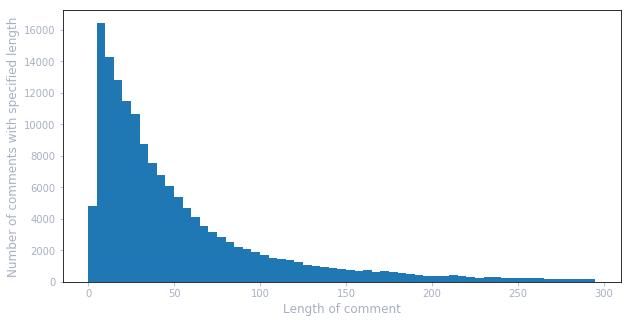

In [33]:
# Analysis of lengths of comments (maxlen param)
n_words_comments = [len(comment) for comment in tokenized_sequences_train]

plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.ylabel('Number of comments with specified length', fontsize=12)
plt.xlabel('Length of comment', fontsize=12)
plt.show()

In [34]:
maxlen = 180

comments_shorter_than_maxlen = [x for x in n_words_comments if x < maxlen]
x = len(comments_shorter_than_maxlen) / len(n_words_comments) * 100

print('Chosen \'maxlen\' include whole content of {0:.2f} % comments'.format(
    len(comments_shorter_than_maxlen) / len(n_words_comments) * 100))

Chosen 'maxlen' include whole content of 92.67 % comments


In [35]:
# Pad vectors
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=maxlen)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=maxlen)

print('Before padding: {0} elements\n'.format(len(tokenized_sequences_train[6])), tokenized_sequences_train[6])
print('\nAfter padding: {0} elements\n'.format(len(fixed_sequences_train[6])), fixed_sequences_train[6])

Before padding: 8 elements
 [1873, 147, 6, 3476, 324, 15, 29, 141]

After padding: 180 elements
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1873  147    6 3476  324   15 

### Building the model

In [40]:
# Define params for model training
batch_size = 64
epochs = 4
n_classes = len(classes_names)
n_samples = len(fixed_sequences_train)

def create_model(lstm_units = 100, 
                 lstm_recurrent_dropout = 0.2, 
                 lstm_return_sequences = True, 
                 dropout_rate = 0.2, 
                 relu_dense_units = 50, 
                 optimizer = 'adam'):
    
    model_lstm = Sequential()
    if check_architecture_config(architecture_params['pretrained_embedding']['use_pretrained_embedding']):
        embedding_layer = Embedding(input_dim=resultant_num_words,
                                    output_dim=embedding_output_dim,
                                    embeddings_initializer=Constant(embedding_matrix),
                                    input_length=maxlen,
                                    trainable=False)
    else:
        embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_output_dim)
    model_lstm.add(embedding_layer)
    model_lstm.add(LSTM(units=lstm_units, 
                        return_sequences=lstm_return_sequences, 
                        recurrent_dropout=lstm_recurrent_dropout))
    model_lstm.add(GlobalMaxPool1D())
    model_lstm.add(Dropout(rate=dropout_rate))
    model_lstm.add(Dense(units=relu_dense_units, activation='relu'))
    model_lstm.add(Dense(n_classes, activation='sigmoid'))
    
    model_lstm.compile(loss='binary_crossentropy', 
                       optimizer=optimizer,
                       metrics=['accuracy'])
    return model_lstm

param_grid = {
    'lstm_units': [100],
    'dropout_rate': [0.2],
    'optimizer': ['adam'],
    'relu_dense_units': [50],
    'lstm_recurrent_dropout': [0.2],
    'lstm_return_sequences': [True]
}

# Define callbacks
name_checkpoint_file = 'checkpoint.weights.hdf5'
checkpoint = ModelCheckpoint(filepath=f'{MODEL_PATH}{name_checkpoint_file}',
                             monitor='val_loss',
                             mode='min',
                             verbose=2,
                             save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=2)

callbacks_list = [checkpoint, early_stopping]

# Create object of KerasClassifier and GridSearch
model = KerasClassifier(build_fn=create_model, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1,
                        verbose=2)

# Necessary because of a library's bug
if architecture_params['pretrained_embedding']['use_pretrained_embedding']['value']:
    n_jobs = None
else:
    n_jobs = -1

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=n_jobs)

# Define data for training
if (architecture_params['markov_oversamping']['oversample_with_markov']['value']):
    print('Use labels from oversampled dataset for training')
    labels_for_training = extended_labels_train
else:
    print('Use labels from original dataset for training')
    labels_for_training = labels_train

X_train = fixed_sequences_train
y_train = labels_for_training

Use labels from original dataset for training


### Model training

In [41]:
time_flag = tap_timer(time_flag, start=True)

grid_result = grid.fit(X_train, 
                       y_train,
                       class_weight=class_weights,
                       callbacks=callbacks_list, 
                       verbose=2)

time_flag = tap_timer(time_flag, start=False)

Following architecture parameter: 'Pretrained embeddings' is inactive
Train on 143613 samples, validate on 15958 samples
Epoch 1/4
 - 541s - loss: 0.0919 - acc: 0.9720 - val_loss: 0.0508 - val_acc: 0.9814

Epoch 00001: val_loss improved from inf to 0.05076, saving model to ../model/checkpoint.weights.hdf5
Epoch 2/4
 - 543s - loss: 0.0467 - acc: 0.9827 - val_loss: 0.0486 - val_acc: 0.9823

Epoch 00002: val_loss improved from 0.05076 to 0.04864, saving model to ../model/checkpoint.weights.hdf5
Epoch 3/4
 - 528s - loss: 0.0418 - acc: 0.9841 - val_loss: 0.0485 - val_acc: 0.9824

Epoch 00003: val_loss improved from 0.04864 to 0.04847, saving model to ../model/checkpoint.weights.hdf5
Epoch 4/4
 - 524s - loss: 0.0377 - acc: 0.9853 - val_loss: 0.0483 - val_acc: 0.9818

Epoch 00004: val_loss improved from 0.04847 to 0.04832, saving model to ../model/checkpoint.weights.hdf5

Operation took 1:37:57 [hh:mm:ss]


In [82]:
architecture_params['search_grid_params'] = grid_result.best_params_
architecture_params['score'] = grid_result.best_score_

print("Best params:\n %s (score: %f)" % (grid_result.best_params_, grid_result.best_score_))

Best params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50} (score: 0.982230)


In [83]:
params = grid_result.cv_results_['params']
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
print('All results:')
for param, mean, std in zip(params, means, stds):
    print('\nSet of params:\n %r\n Mean: (%f); Standard deviation: %f' % (param, mean, std))

All results:

Set of params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50}
 Mean: (0.982230); Standard deviation: 0.000132


##### Save and load model

In [84]:
model_name = 'simple'
model_file = f'{model_name}.model.json'
weights_file = f'{model_name}.weights.h5'
config_file = f'{model_name}.config.json'

def create_directory(dirName):
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory",dirName, "created")
    else:    
        print("Directory",dirName, "already exists")

def save_model_to_JSON(model):
    model_file = f'{model_name}.model.json'
    file_dir = f'{MODEL_PATH}{model_name}'
    
    create_directory(file_dir)
    model_json = model.to_json()
    with open(f'{file_dir}/{model_file}', 'w') as json_file:
        json_file.write(model_json)
    print('Saved "{0}" model to disk'.format(model_name))
        
def save_weights_to_HDF5(model):
    model.save_weights(f'{MODEL_PATH}{model_name}/{weights_file}')
    print('Saved weights of "{0}" model to disk'.format(model_name))

def save_architecture_config(dict_params):
    with open(f'{MODEL_PATH}{model_name}/{config_file}',"w") as fp:
        json.dump(architecture_params, fp, sort_keys=True, indent=4)
    print('Saved architecture config of "{0}" model'.format(model_name))
    
def load_json_wih_weights_to_model():
    json_file = open(f'{MODEL_PATH}{model_name}/{model_file}', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f'{MODEL_PATH}{model_name}/{weights_file}')
    print('Loaded \'%s\' model with weights from disk' % model_name)
    return loaded_model

In [85]:
# Save model and architecture conifg
best_model = grid_result.best_estimator_.model

save_model_to_JSON(best_model)
save_weights_to_HDF5(best_model)
save_architecture_config(architecture_params)

Directory ../model/simple already exists
Saved "simple" model to disk
Saved weights of "simple" model to disk
Saved architecture config of "simple" model


In [86]:
# Load model
loaded_model = load_json_wih_weights_to_model()
loaded_model.summary()

Loaded 'simple' model with weights from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,585,756
Trainable params: 2,585,756
Non-trainable params: 0
_____________________

##### Predicting on test dataset

In [87]:
def drop_entries_with_invalid_labels(test, test_labels):
    indexes_invalid_labels = test_labels.index[test_labels['toxic'] == -1].tolist()
    valid_test_labels = test_labels.drop(test_labels.index[indexes_invalid_labels]).reset_index(drop=True)
    valid_test = np.delete(test, indexes_invalid_labels, axis=0)
    assert (valid_test_labels.shape[0] == len(valid_test))
    return valid_test, valid_test_labels

def extend_labels_test(labels_test):
    extended_test_labels = labels_test
    test_labels_sums = labels_test.sum(axis=1)
    extended_test_labels["clean"] = (test_labels_sums == 0)
    return extended_test_labels

# prepare test dataset
test_labels_without_ids = test_labels.iloc[:,1:]
X_test, y_test_df = drop_entries_with_invalid_labels(fixed_sequences_test, test_labels_without_ids)

if (extend_labels_by_clean):
    y_test_df = extend_labels_test(y_test_df)

In [88]:
time_flag = tap_timer(time_flag, start=True)

y_pred_float = loaded_model.predict([X_test], batch_size=1024)
y_pred = (y_pred_float > .5)
y_test = y_test_df.values

time_flag = tap_timer(time_flag, start=False)


Operation took 0:01:12 [hh:mm:ss]


##### Use metrics for imbalanced learning

In [90]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action="ignore",category=UndefinedMetricWarning)

with warnings.catch_warnings():
    print('Some classes has no predicted samples!')

precision, recall, fscore, support = score(y_test, y_pred)
kappa = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
specificity = specificity_score(y_test.ravel(), y_pred.ravel())
sensitivity = sensitivity_score(y_test.ravel(), y_pred.ravel())

Some classes has no predicted samples!


In [91]:
print('Precision: \t', list(map('{:.3f}'.format, precision)))
print('Recall: \t', list(map('{:.3f}'.format, recall)))
print('F1 score: \t', list(map('{:.3f}'.format, fscore)))
print('Support: \t', support)
print('\n --- \n')
print('Kappa score: \t{:.3f}'.format(kappa))
print('Specificity: \t{:.3f}'.format(specificity))
print('Sensitivity: \t{:.3f}'.format(sensitivity))

Precision: 	 ['0.541', '0.352', '0.632', '0.000', '0.656', '0.000']
Recall: 	 ['0.843', '0.480', '0.750', '0.000', '0.640', '0.000']
F1 score: 	 ['0.659', '0.406', '0.686', '0.000', '0.648', '0.000']
Support: 	 [6090  367 3691  211 3427  712]

 --- 

Kappa score: 	0.622
Specificity: 	0.980
Sensitivity: 	0.708


Confusion matrices:


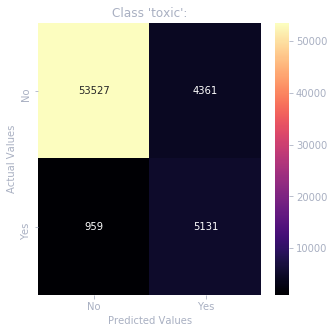

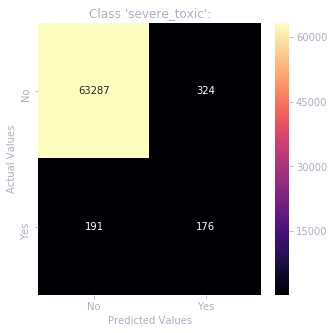

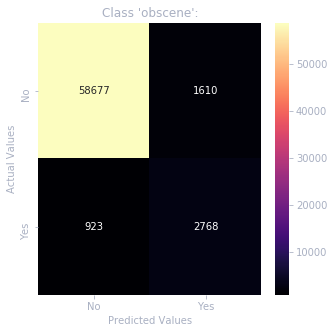

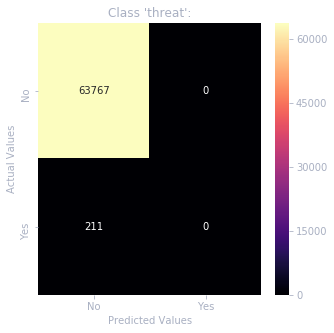

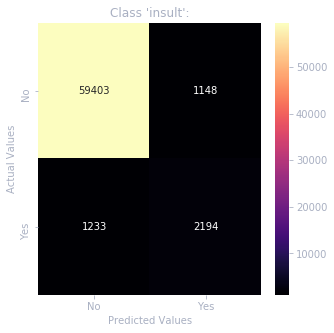

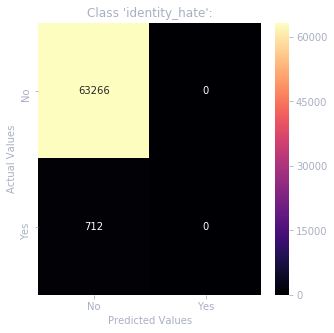

In [92]:
conf_matrices = {}
for label in range(len(classes_names)):
    y_test_label = y_test[:, label]
    y_pred_label = y_pred[:, label]
    conf_matrices[classes_names[label]] = confusion_matrix(y_pred=y_pred_label, y_true=y_test_label)
    
print("Confusion matrices:")
for label, matrix in conf_matrices.items():
    df_cm = pd.DataFrame(matrix, index = [i for i in ['No', 'Yes']], columns = [i for i in ['No', 'Yes']])
    plt.figure(figsize = (5, 5))
    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, cmap='magma', fmt='g')
    ax.set_title("Class '{}':".format(label))
    ax.set_ylabel('Actual Values')    
    ax.set_xlabel('Predicted Values')
    plt.show()

##### Create submission file

##### Manual model testing

In [95]:
def prepare_manual_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=maxlen)

single_comment = 'I will eat your ice cream'
single_prediction = loaded_model.predict([prepare_manual_comment([single_comment])], batch_size=1024)
results = pd.DataFrame(single_prediction, columns=[classes_names])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)


No toxicity detected!

 \ (•◡•) /

All results:
       toxic severe_toxic   obscene    threat    insult identity_hate
0  0.300303     0.001268  0.035309  0.005599  0.044181       0.00849


##### <font color="#7affa0">Improvements:</font>

- two-level classification: binary (clean/toxic data) + multi-label (only toxic data)
- hierarchical classification (check correlation table)
- oversampling with One-vs-rest classification (6 classifiers)
- find additional datasets with comments of minor classes